# Прогнозирование оттока клиентов

## Описание проекта
Оператор связи «Телеком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Цель:** Построить модель для прогнозирования оттока клиентов компании, оказывающей услуги интернета и телефонии.

Метрика auc_roc должна быть не ниже 85%

### Описание услуг

**Основные:**
1. Стационарная телефонная связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

**Дополнительные:**
- интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- выделенная линия технической поддержки (*TechSupport*);
- облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре
 - customerID – уникальный номер клиента
 - BeginDate – дата начала пользования услугами
 - EndDate – дата окончания пользования услугами
 - Type – тип оплаты: ежемесячный, годовой и тд
 - PaperlessBilling – электронный платёжный документ
 - PaymentMethod – способ оплаты
 - MonthlyCharges – ежемесячные траты на услуги
 - TotalCharges – всего потрачено денег на услуги
 
 
- `personal_new.csv` — персональные данные клиента
  - customerID – уникальный номер клиента
  - gender — пол клиента
  - Dependents – наличие иждивенцев
  - Senior Citizen – наличие пенсионного статуса по возрасту
  - Partner – наличие супруга(и)
  
  
- `internet_new.csv` — информация об интернет-услугах
   - customerID – уникальный номер клиента
   - InternetService — типы подключения: через телефонную линию (DSL) или оптоволоконный кабель (Fiber optic)
   - DeviceProtection — антивирус
   - OnlineSecurity — блокировка небезопасных сайтов
   - TechSupport — выделенная линия технической поддержки
   - OnlineBackup — облачное хранилище файлов для резервного копирования данных
   - StreamingTV — стриминговое телевидение
   - StreamingMovies — каталог фильмов
   
   
- `phone_new.csv` — информация об услугах телефонии
    - customerID – уникальный номер клиента
    - MultipleLines – наличие возможности ведения параллельных линий во время звонка

Информация о договорах актуальна на 1 февраля 2020.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Выбор-и-обучение-модели" data-toc-modified-id="Выбор-и-обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Выбор и обучение модели</a></span></li><li><span><a href="#Отчет-по-проекту" data-toc-modified-id="Отчет-по-проекту-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Отчет по проекту</a>

# Исследовательский анализ данных

## Предобработка данных

Импортируем библиотеки pandas, numpy, seaborn и sklearn для дальнейшей работы:

In [1]:
!pip install phik
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from phik import phik_matrix

RANDOM_STATE = 120623

In [2]:
try:
    data_contract = pd.read_csv(r'C:\Users\Julia\Desktop\DATA_SCIENCE\Datasets\contract_new.csv')
    data_personal = pd.read_csv(r'C:\Users\Julia\Desktop\DATA_SCIENCE\Datasets\personal_new.csv')
    data_internet = pd.read_csv(r'C:\Users\Julia\Desktop\DATA_SCIENCE\Datasets\internet_new.csv')
    data_phone = pd.read_csv(r'C:\Users\Julia\Desktop\DATA_SCIENCE\Datasets\phone_new.csv')
except:
    data_contract = pd.read_csv('/datasets/contract_new.csv')
    data_personal = pd.read_csv('/datasets/personal_new.csv')
    data_internet = pd.read_csv('/datasets/internet_new.csv')
    data_phone = pd.read_csv('/datasets/phone_new.csv')

Напишем функцию `show`, с помощью которой проверим данные каждого датафрейма на наличие дубликатов, пропущенных значений, выведем общую информацию датафрейма, размер таблицы и посмотрим первые 5 строк с помощью метода `head()`

### data_contract:

In [3]:
def show (data):
    print('Количество дубликатов:', data.duplicated().sum(), '\n')
    print('Количество пропущенных значений:\n', data.isna().sum(), '\n')
    print('Размер таблицы:', data.shape, '\n')
    data.info()
    return data.head()
show(data_contract)

Количество дубликатов: 0 

Количество пропущенных значений:
 customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64 

Размер таблицы: (7043, 8) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


Дубликаты и пропущенные значения в данных не найдены. Проверим данные на неявные пропуски, посмотрим на содержание столбцов и изменим типы данных на верные:

Начнем со столбца `BeginDate`, изменим тип данных с object на datetime

In [4]:
data_contract['BeginDate'] =  data_contract['BeginDate'].apply(pd.to_datetime)

Теперь посмотрим на содержание столбца `EndDate`

In [5]:
data_contract['EndDate'].sort_values().value_counts()

No            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2014-09-01       2
2014-12-01       2
2014-11-01       1
2014-10-01       1
2014-06-01       1
Name: EndDate, Length: 67, dtype: int64

Значение 'No' говорит о том, что на момент выгрузки данных клиент был действующим и не расторгал договор, с помощью sort_value можно увидеть, что максимальная дата окончания договора - это 01 января 2020, значит можно заменить значения `No` на `2020-02-01` и привести признак к типу данных datetime:

In [6]:
data_contract['EndDate'] = data_contract['EndDate'].replace('No','2020-02-01')
data_contract['EndDate'] =  data_contract['EndDate'].apply(pd.to_datetime)
data_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](2), float64(1), object(5)
memory usage: 440.3+ KB


Проверим уникальные значения столбцов `Type`, `PaymentMethod`, `PaperlessBilling`:

In [7]:
print('Уникальные значения Type: ', data_contract['Type'].unique())
print('Уникальные значения PaymentMethod: ', data_contract['PaymentMethod'].unique())
print('Уникальные значения PaperlessBilling: ', data_contract['PaperlessBilling'].unique())

Уникальные значения Type:  ['Month-to-month' 'One year' 'Two year']
Уникальные значения PaymentMethod:  ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Уникальные значения PaperlessBilling:  ['Yes' 'No']


Проверка показала, что значения данных признаков выглядят корректно

Отдельно проверим уникальные значения в столбцах `MonthlyCharges` и `TotalCharges`, предварительно отсортировав их в порядке возрастания, так мы сможем дополнительно увидеть минимальные и максимальные значения:

In [8]:
print('Уникальные значения MonthlyCharges: ', data_contract['MonthlyCharges'].sort_values().unique())
print('Уникальные значения TotalCharges: ', data_contract['TotalCharges'].sort_values().unique())

Уникальные значения MonthlyCharges:  [ 18.25  18.4   18.55 ... 118.6  118.65 118.75]
Уникальные значения TotalCharges:  [' ' '100.17' '100.19' ... '998.89' '999.6' '999.9']


Значения признака `MonthlyCharges` выглядят корректно, а в `TotalCharges` обнаружены пропуски, выгрузим их:

In [9]:
print('Доля пропущенных значений TotalCharges:', round(len(data_contract[data_contract['TotalCharges'] == ' '])/
                                                len(data_contract['TotalCharges']),4)*100, '%')
data_contract[data_contract['TotalCharges'] == ' ']

Доля пропущенных значений TotalCharges: 0.16 %


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,


По данным видно, что пропущенные значения в `TotalCharges` относятся к пользователям, подключенным к тарифу в день выгрузки базы данных (2020-02-01), таких значений слишком мало (менее 1%) и они никак не повлияют на результат, удалим их из выборки, а также заменим тип данных object на float:

In [10]:
data_contract = data_contract.loc[data_contract['TotalCharges'] != ' ']
data_contract['TotalCharges'] = data_contract['TotalCharges'].astype('float64')
data_contract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   datetime64[ns]
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 494.4+ KB


Целевым признаком является факт ухода клиента из компании, выделим его в отдельный столбец `left_the_company`, в котором значение 0 - клиент компании, 1 - клиент, покинувший компанию:

In [11]:
data_contract.loc[data_contract['EndDate'] == '2020-02-01', 'left_the_company'] = 0
data_contract.loc[data_contract['EndDate'] != '2020-02-01', 'left_the_company'] = 1

Cоздадим признак `days_at_company`, показывающий как долго клиент находится в компании (он понадобится нам для дальнейшего анализа)

In [12]:
data_contract['days_at_company'] = (data_contract['EndDate'] - data_contract['BeginDate']).dt.days
data_contract.sample(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,left_the_company,days_at_company
3863,0365-BZUWY,2018-09-01,2020-02-01,Month-to-month,Yes,Electronic check,102.55,1813.08,0.0,518
3933,5396-IZEPB,2019-05-01,2020-02-01,Month-to-month,No,Credit card (automatic),19.70,177.30,0.0,276
6835,7964-ZRKKG,2014-07-01,2020-02-01,One year,Yes,Bank transfer (automatic),88.40,6455.85,0.0,2041
1716,5515-RUGKN,2019-06-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),54.75,438.00,0.0,245
7014,9053-EJUNL,2016-09-01,2020-02-01,Month-to-month,Yes,Electronic check,89.20,3803.49,0.0,1248


Названия признаков выглядят некорректно и затрудняют читаемость, приведем их к snake_case:

In [13]:
data_contract.rename(columns={'customerID': 'customer_id'}, inplace=True)
data_contract.rename(columns={'BeginDate': 'begin_date'}, inplace=True)
data_contract.rename(columns={'EndDate': 'end_date'}, inplace=True)
data_contract.rename(columns={'Type': 'type'}, inplace=True)
data_contract.rename(columns={'PaperlessBilling': 'paperless_billing'}, inplace=True)
data_contract.rename(columns={'PaymentMethod': 'payment_method'}, inplace=True)
data_contract.rename(columns={'MonthlyCharges': 'monthly_charges'}, inplace=True)
data_contract.rename(columns={'TotalCharges': 'total_charges'}, inplace=True)

data_contract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           7032 non-null   datetime64[ns]
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   object        
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   left_the_company   7032 non-null   float64       
 9   days_at_company    7032 non-null   int64         
dtypes: datetime64[ns](2), float64(3), int64(1), object(4)
memory usage: 604.3+ KB


Данные по data_contract обработаны, переходим к следующей выборке

### data_personal:

In [14]:
show(data_personal)

Количество дубликатов: 0 

Количество пропущенных значений:
 customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64 

Размер таблицы: (7043, 5) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Данная таблица выглядит без явных ошибок, дубликатов нет, изменим только тип данных признака `SeniorCitizen` и заменим 1 и 0 на Yes и No(потому что он не числовой, а говорит нам о том является ли клиент пенсинером или нет), проверим уникальные значения и приведем названия столбцов к snake_case:

In [15]:
data_personal['SeniorCitizen'] = data_personal['SeniorCitizen'].replace(0, 'No')
data_personal['SeniorCitizen'] = data_personal['SeniorCitizen'].replace(1, 'Yes')
data_personal['SeniorCitizen'] = data_personal['SeniorCitizen'].astype('object')


print('Уникальные значения gender: ', data_personal['gender'].unique())
print('Уникальные значения SeniorCitizen: ', data_personal['SeniorCitizen'].unique())
print('Уникальные значения Partner: ', data_personal['Partner'].unique())
print('Уникальные значения Dependents: ', data_personal['Dependents'].unique())

Уникальные значения gender:  ['Female' 'Male']
Уникальные значения SeniorCitizen:  ['No' 'Yes']
Уникальные значения Partner:  ['Yes' 'No']
Уникальные значения Dependents:  ['No' 'Yes']


In [16]:
data_personal.rename(columns={'customerID': 'customer_id'}, inplace=True)
data_personal.rename(columns={'SeniorCitizen': 'senior_citizen'}, inplace=True)
data_personal.rename(columns={'Partner': 'partner'}, inplace=True)
data_personal.rename(columns={'Dependents': 'dependents'}, inplace=True)
data_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   object
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB


Данные по data_personal обработаны, переходим к следующей выборке

### data_internet:

In [17]:
show(data_internet)

Количество дубликатов: 0 

Количество пропущенных значений:
 customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64 

Размер таблицы: (5517, 8) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Данная таблица выглядит без явных ошибок, дубликатов нет, типы данных верные, проверим уникальные значения и приведем названия столбцов к snake_case:

In [18]:
print('Уникальные значения InternetService: ', data_internet['InternetService'].unique())
print('Уникальные значения OnlineSecurity: ', data_internet['OnlineSecurity'].unique())
print('Уникальные значения OnlineBackup: ', data_internet['OnlineBackup'].unique())
print('Уникальные значения DeviceProtection: ', data_internet['DeviceProtection'].unique())
print('Уникальные значения TechSupport: ', data_internet['TechSupport'].unique())
print('Уникальные значения StreamingTV: ', data_internet['StreamingTV'].unique())
print('Уникальные значения StreamingMovies: ', data_internet['StreamingMovies'].unique())

Уникальные значения InternetService:  ['DSL' 'Fiber optic']
Уникальные значения OnlineSecurity:  ['No' 'Yes']
Уникальные значения OnlineBackup:  ['Yes' 'No']
Уникальные значения DeviceProtection:  ['No' 'Yes']
Уникальные значения TechSupport:  ['No' 'Yes']
Уникальные значения StreamingTV:  ['No' 'Yes']
Уникальные значения StreamingMovies:  ['No' 'Yes']


In [19]:
data_internet.rename(columns={'customerID': 'customer_id'}, inplace=True)
data_internet.rename(columns={'InternetService': 'internet_service'}, inplace=True)
data_internet.rename(columns={'OnlineSecurity': 'online_security'}, inplace=True)
data_internet.rename(columns={'OnlineBackup': 'online_backup'}, inplace=True)
data_internet.rename(columns={'DeviceProtection': 'device_protection'}, inplace=True)
data_internet.rename(columns={'TechSupport': 'tech_support'}, inplace=True)
data_internet.rename(columns={'StreamingTV': 'streaming_tv'}, inplace=True)
data_internet.rename(columns={'StreamingMovies': 'streaming_movies'}, inplace=True)
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Данные по data_internet обработаны, переходим к следующей выборке

### data_phone:

In [20]:
show(data_phone)

Количество дубликатов: 0 

Количество пропущенных значений:
 customerID       0
MultipleLines    0
dtype: int64 

Размер таблицы: (6361, 2) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Данная таблица выглядит без явных ошибок, дубликатов нет, типы данных верные, проверим уникальные значения и приведем названия столбцов к snake_case:

In [21]:
print('Уникальные значения MultipleLines: ', data_phone['MultipleLines'].unique())

Уникальные значения MultipleLines:  ['No' 'Yes']


In [22]:
data_phone.rename(columns={'customerID': 'customer_id'}, inplace=True)
data_phone.rename(columns={'MultipleLines': 'multiple_lines'}, inplace=True)
data_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Объединим все выборки в один датафрейм. При объединении таблиц вместо пустых значений признаков укажем `No`, выведем последние 5 строк объединенного датафрейма:

In [23]:
data = data_contract.merge(data_personal, on='customer_id', how='left').merge(data_internet, on='customer_id',how='left')\
.merge(data_phone, on='customer_id', how='left').fillna('No')
data.set_index('customer_id', inplace=True)
data.tail()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,left_the_company,days_at_company,gender,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customer_id,,,,,,,,,,,,,,,,,,,,,
6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,2035.20,0.0,730,Male,...,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7430.40,0.0,2191,Female,...,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,325.60,0.0,337,Female,...,Yes,Yes,DSL,Yes,No,No,No,No,No,No
8361-LTMKD,2019-07-01,2020-02-01,Month-to-month,Yes,Mailed check,74.40,520.80,0.0,215,Male,...,Yes,No,Fiber optic,No,No,No,No,No,No,Yes
3186-AJIEK,2014-08-01,2020-02-01,Two year,Yes,Bank transfer (automatic),105.65,7251.82,0.0,2010,Male,...,No,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,No


Мы провели предобработку: проверили данные на явные и неявные дубликаты, избавились от пропущенных значений, привели названия столбцов всех датафреймов к snake_case, изменили типы данных значений на верные и объединили все датафрейы в один. Переходим к анализу данных.

## Анализ данных

Начнем с распределения целевого признака `left_the_company`:

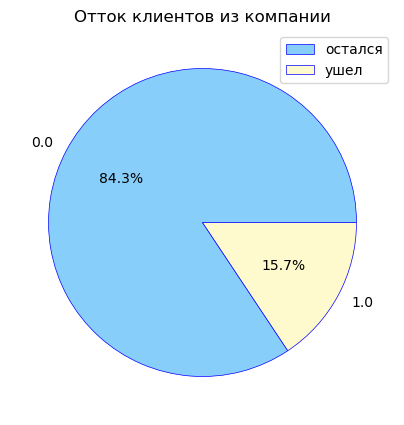

In [24]:
data['left_the_company'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(5,5),
                                                      colors=['#87CEFA', '#FFFACD'],
                                 wedgeprops={'edgecolor': 'blue', 'linewidth': 0.5})
plt.legend(['остался','ушел'])
plt.title('Отток клиентов из компании')
plt.axis('off');

Диаграмма наглядно показывает, что компанию покинуло 15.7% клиентов, присутствует дисбаланс классов

Выгрузим графики количественных признаков и посмотрим на матрице корреляции с каким признаком наиболее связан уход клиента

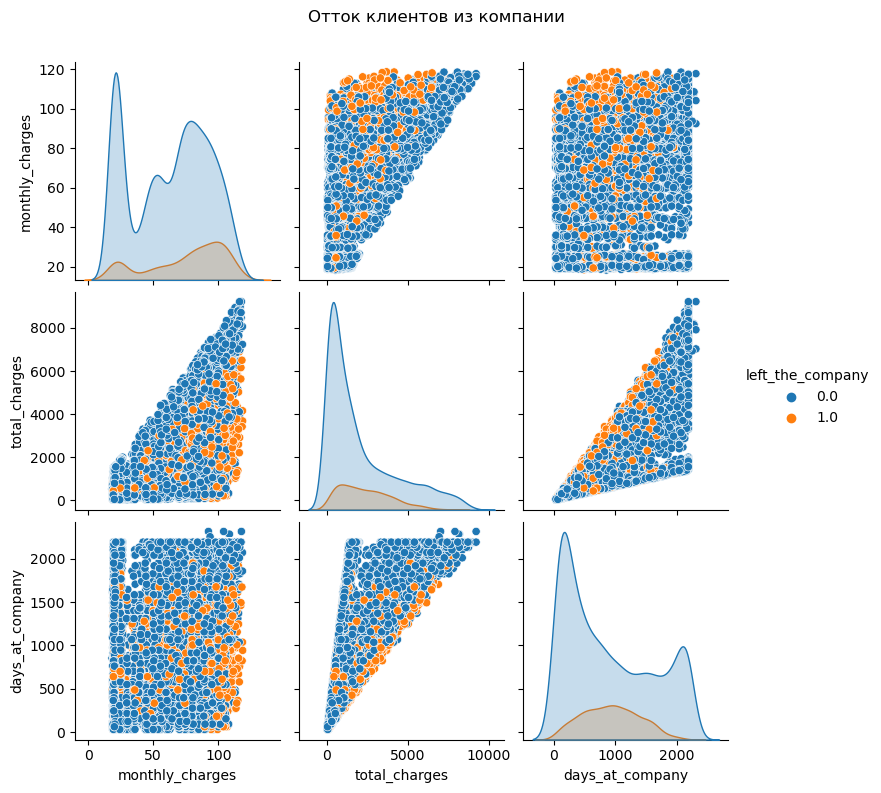

In [25]:
sns.pairplot(data, hue='left_the_company').fig.suptitle('Отток клиентов из компании', y=1.05);

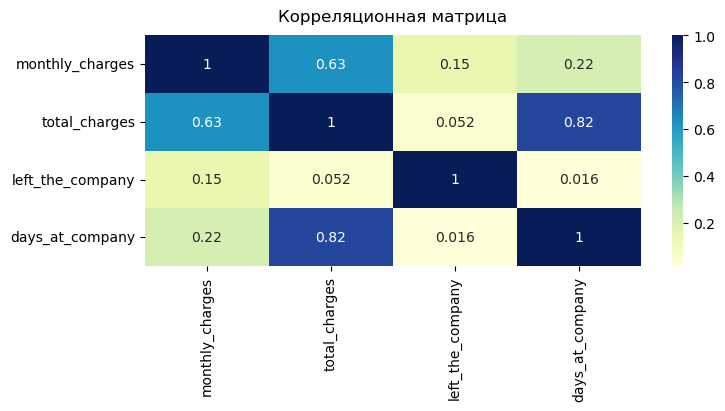

In [26]:
plt.figure(figsize=(8,3))
ax = plt.subplot()
sns.heatmap(data.corr(), annot=True, cmap="YlGnBu", fmt ='.2g')
ax.set_title('Корреляционная матрица', y=1.025);

Графики наглядно показывают, что уход клиента из компании наиболее зависим от ежемесячной оплаты, а также признаки total_charges и days_at_company сильно коррелируют между собой, что логично - чем больше дней, тем больше общая сумма платежа. Посмотрим более подробно на ежемесячные платежи, общую сумму платежей и времени в компании оставшихся клиентов и ушедших из компании:

In [27]:
data.groupby('left_the_company').agg({'total_charges' : ['min', 'max', 'mean','median'],
                                      'monthly_charges' : ['min', 'max', 'mean','median'],
                                      'days_at_company' : ['min', 'max', 'mean','median']})

total_charges                                monthly_charges  \
                           min      max         mean   median             min   
left_the_company                                                                
0.0                      19.05  9221.38  2071.701614  1194.28           18.25   
1.0                      77.84  7649.76  2371.377275  2139.03           18.40   

                                           days_at_company                   \
                     max       mean median             min   max       mean   
left_the_company                                                              
0.0               118.60  62.803043  69.25              31  2314  895.33856   
1.0               118.75  75.546004  84.20              28  2129  924.86376   

                         
                 median  
left_the_company         
0.0               702.0  
1.0               915.0

В среднем ушедшие клиенты тратили в месяц больше (median 84.2), сумма платежей ушедших клиентов в среднем значительно превышает оставшихся (median 2139), а также минимальная сумма платежей ушедших пользователей превышает сумму оставшихся в 3 раза. Из данной таблицы следует вывод о том, что ушедшие пользователи тратили больше, чем оставшиеся. По длительности пребывания в компании, клиенты, ушедшие из нее, являлись клиентами компании дольше (median 915 дней). Посмотрим подробно как использовались клиентами интернет услуги. Сначала рассмотрим использование услуг клиентами, которые ушли из компании: 

In [28]:
data_left = data[data['left_the_company'] == 1]
data_stay = data[data['left_the_company'] == 0]

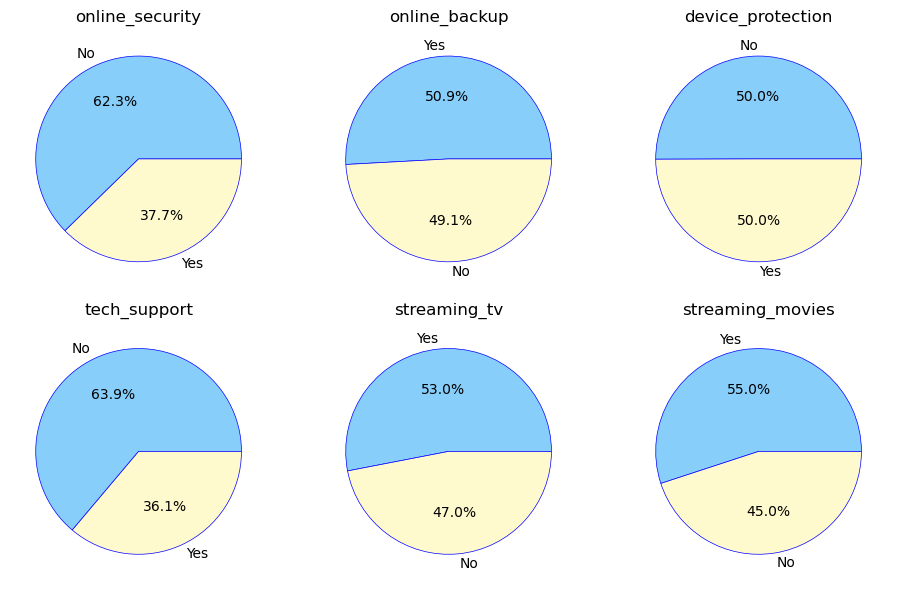

In [29]:
def visual_pie(df, column, index_x, index_y):
    df[column].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=axes[index_x, index_y],
                                                 colors=['#87CEFA', '#FFFACD', 'lightgray'],
                                                 wedgeprops={'edgecolor': 'blue', 'linewidth': 0.5})
    axes[index_x,index_y].set_title(column)
    axes[index_x,index_y].axis('off')
    plt.tight_layout()
    
fig, axes = plt.subplots(2, 3, figsize=(10, 6))

visual_pie(data_left, 'online_security', 0, 0)
visual_pie(data_left, 'online_backup', 0, 1)
visual_pie(data_left, 'device_protection', 0, 2)
visual_pie(data_left, 'tech_support', 1, 0)
visual_pie(data_left, 'streaming_tv', 1, 1)
visual_pie(data_left, 'streaming_movies', 1, 2)

Мы видим, что у половины ушедших пользователей были подключены дополнительные интернет-услуги, это объясняет более высокие ежемесячные платежи и общие суммы выплат. Теперь посмотрим используют ли данные услуги клиенты,оставшиеся в компании:

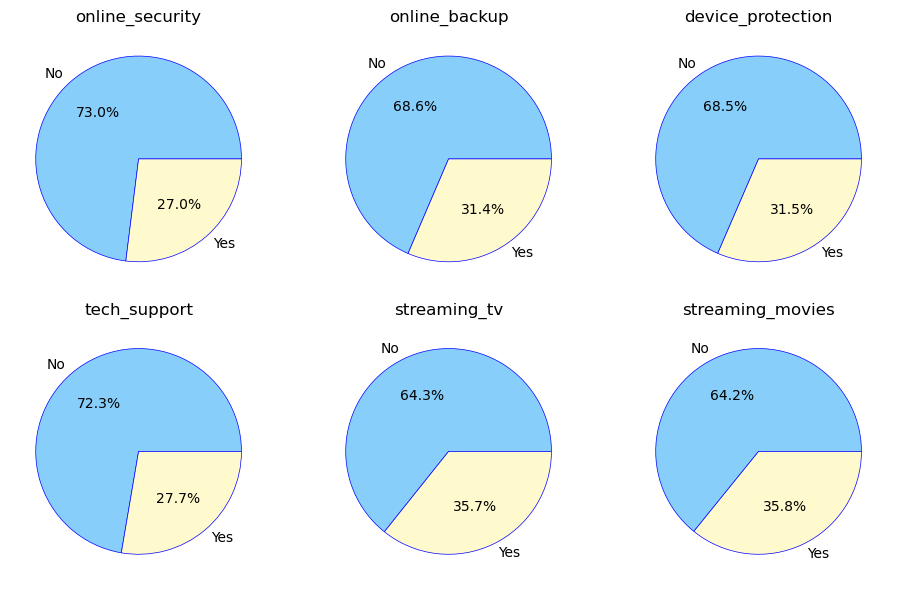

In [30]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6))

visual_pie(data_stay, 'online_security', 0, 0)
visual_pie(data_stay, 'online_backup', 0, 1)
visual_pie(data_stay, 'device_protection', 0, 2)
visual_pie(data_stay, 'tech_support', 1, 0)
visual_pie(data_stay, 'streaming_tv', 1, 1)
visual_pie(data_stay, 'streaming_movies', 1, 2)

Мы видим, что большинство оставшихся клиентов не используют дополнительные интернет-услуги, также признаки `straming_tv` и `stremaing_movies` имеют практически одинаковое соотношение как среди ушедших, так и среди оставшихся, возможно эти две услуги связаны между собой, например подпиской. Сравним использование мультиканальной связи ушедших клиентов и оставшихся, а также их типы контрактов:

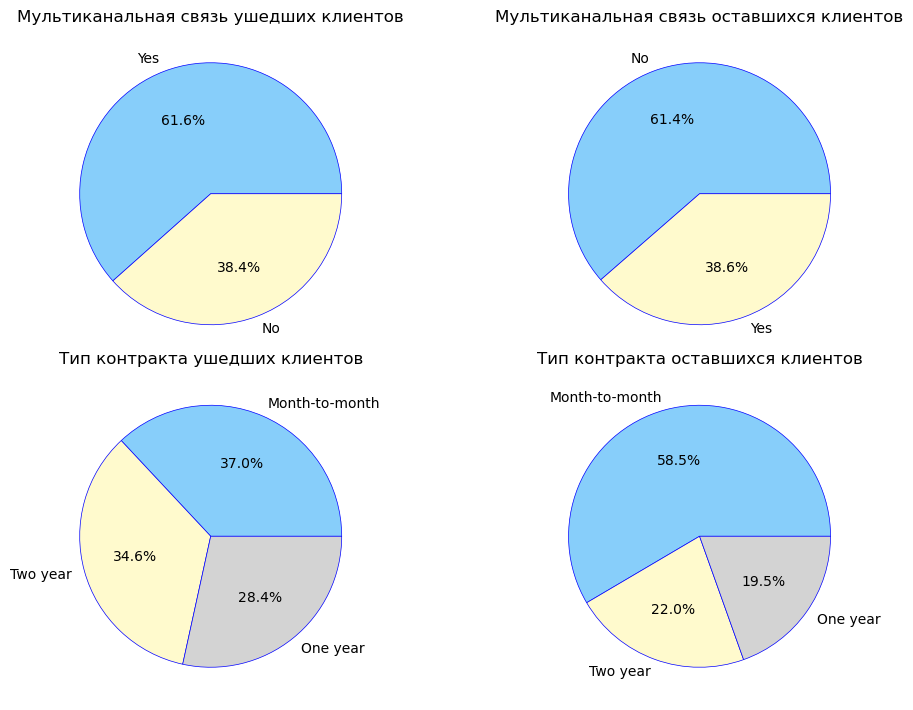

In [31]:
def visual_pie_2(df, column, index_x, index_y):
    df[column].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=axes[index_x, index_y],
                                                 colors=['#87CEFA', '#FFFACD', 'lightgray'],
                                                 wedgeprops={'edgecolor': 'blue', 'linewidth': 0.5})
    axes[index_x, index_y].axis('off')
    plt.tight_layout()
    
fig, axes = plt.subplots(2, 2, figsize=(14, 7))
plt.subplots_adjust(hspace=0.2)

visual_pie_2(data_left, 'multiple_lines', 0, 0)
visual_pie_2(data_stay, 'multiple_lines', 0, 1)
visual_pie_2(data_left, 'type', 1, 0)
visual_pie_2(data_stay, 'type', 1, 1)

axes[0,0].set_title('Мультиканальная связь ушедших клиентов')
axes[0,1].set_title('Мультиканальная связь оставшихся клиентов')
axes[1,0].set_title('Тип контракта ушедших клиентов')
axes[1,1].set_title('Тип контракта оставшихся клиентов');

Ушедшие клиенты также в большинстве своем пользовались услугами многоканальной связи, а оставшиеся преимущественно не используют данную услугу, также ушедшие клиенты чаще выбирали долгосрочные типы оплаты, а оставшиеся платили от месяца к месяцу. Посмотрим на распределение персональных признаков клиентов:

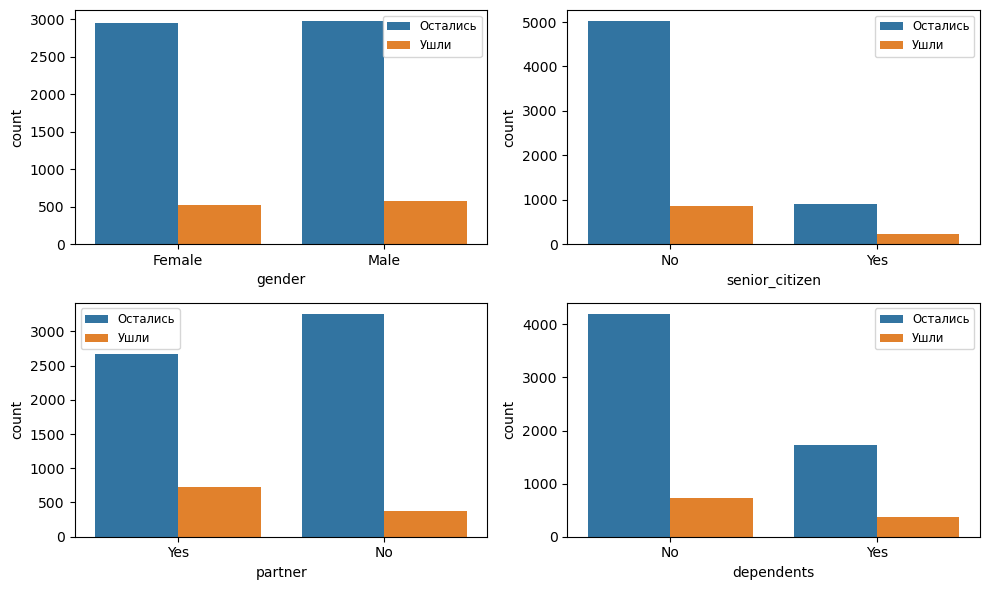

In [32]:
def visual_column(column, index_x, index_y):
    sns.countplot(x=column, hue='left_the_company', data=data, ax=axes[index_x, index_y])
    plt.tight_layout()
    axes[index_x, index_y].legend(['Остались', 'Ушли'], fontsize='small')
    
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
visual_column('gender', 0, 0)
visual_column('senior_citizen', 0, 1)
visual_column('partner', 1, 0)
visual_column('dependents', 1, 1)

Исходя из графиков можно сделать вывод о том, что гендер, наличие у клиента иждивенцев и статус пенсионера не влияют на уход из компании, при этом клиенты без партнера чаще оставались в компании и реже уходили. На основе проведенного анализа удалим признаки, которые не повлияют на качество модели - это `begin_date`и `end_date` так как вместо них мы добавили признак `days_at_company` и персональные данные одинаково влияющие на факт ухода `gender`, `senior_citizen` и `dependents`. Построим корреляционну матрицу всех признаков, чтобы удалить ненужные и посмотреть на зависимости:

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'left_the_company', 'days_at_company']


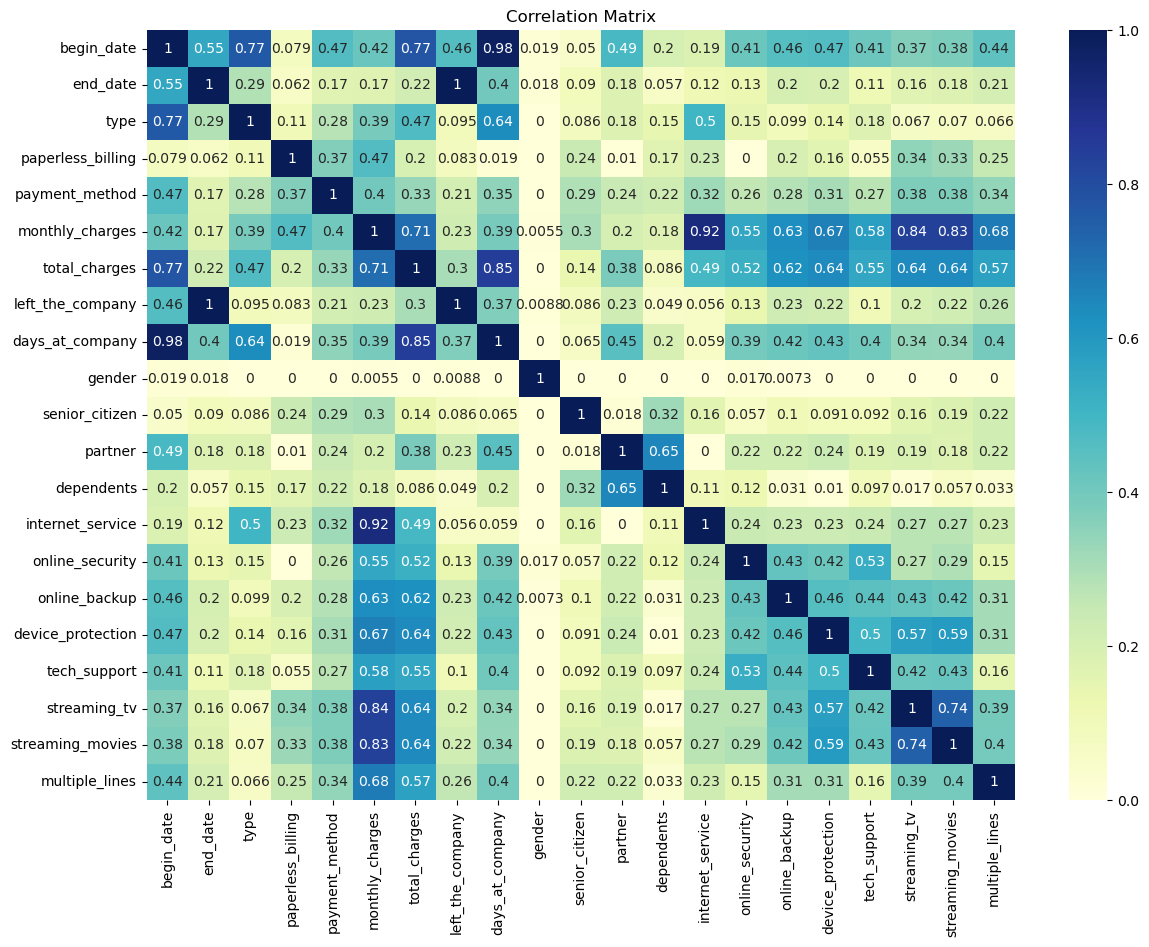

In [33]:
phik_matrix_data = data.phik_matrix()
plt.figure(figsize=(14, 10))
sns.heatmap(phik_matrix_data, annot=True, cmap='YlGnBu')
plt.title('Correlation Matrix')
plt.show()

Избавимся от неважных признаков (слабокоррелирующих с целевым) и выведем датафрейм после всех изменений:

In [34]:
data.drop(['begin_date', 'end_date', 'gender', 'senior_citizen', 'dependents'], axis=1, inplace=True)
data.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,left_the_company,days_at_company,partner,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customer_id,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0.0,31,Yes,DSL,No,Yes,No,No,No,No,No
5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0.0,1036,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0.0,123,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,0.0,1371,No,DSL,Yes,No,Yes,Yes,No,No,No
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,0.0,153,No,Fiber optic,No,No,No,No,No,No,No


**Вывод:**
- мы импортировали нужные библиотеки и провели предобработку данных (преобразовали типы данных, проверили их на буликаты, избавились от пропущенных значений, названия признаков привели к snake_case, объединили все датафреймы в один)
- провели исследовательский анализ данных и выяснили, что компанию покинуло 15.7% клиентов
- построили графики оттока клиентов и корреляционную матрицу числовых признаков, которые показали, что уход клиента из компании наиболее зависим от ежемесячной оплаты
- в среднем ушедшие клиенты платили в месяц больше, чем оставшиеся, сумма платежей ушедших клиентов в среднем значительно превышает оставшихся, а также минимальная сумма платежей ушедших пользователей превышает сумму оставшихся в 3 раза. По длительности пребывания в компании, клиенты, ушедшие из нее, являлись клиентами компании дольше.
- у половины ушедших клиентов были подключены дополнительные интернет-услуги, это объясняет более высокие ежемесячные платежи и общие суммы выплат
- сравнили использование мальтиканальной связи и типы оплаты оставшимихся пользователей и ушедших, и выяснили, что ушедшие клиенты в большинстве своем пользовались услугами многоканальной связи, а оставшиеся преимущественно не используют данную услугу, также ушедшие клиенты чаще выбирали долгосрочные типы оплаты, а оставшиеся платили от месяца к месяцу
- построили графики персональных данных и сделали вывод о том, что гендер, наличие у клиента иждивенцев и статус пенсионера не влияют на уход из компании, при этом клиенты без партнера чаще оставались в компании и реже уходили
- избавились от ненужных признаков

# Выбор и обучение модели

### Подготовка данных

Исследуем дисбаланс классов целевого признака `left_the_company`:

In [35]:
data['left_the_company'].value_counts(normalize=True) * 100

0.0    84.343003
1.0    15.656997
Name: left_the_company, dtype: float64

Видим, что из компании ушли 16% клиентов, классы не сбалансированы, но наша метрика не чувствительна к дисбалансу, поэтому балансировать данные не будем.

Сохраним в переменных `features` и `target` признаки и целевой признак и разделим выборку на обучающую и тестовую в соотношении 3:1:

In [36]:
features = data.drop('left_the_company',axis=1)
target = data['left_the_company']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.25,
                                                                            random_state=RANDOM_STATE)
print(f'Размер обучающей выборки: {len (features_train) / len(data):.0%}')
print(f'Размер тестовой выборки: {len (features_test) / len(data):.0%}')

Размер обучающей выборки: 75%
Размер тестовой выборки: 25%


Преобразуем категориальные признаки, используя метод One-Hot Encoding (OHE), запишем категориальные и числовые признаки в переменные `categorical` и `numeric`, и применим масштабирование с помощью метода StandardScaler к числовым признакам:

In [37]:
numeric = features_train.select_dtypes(include=['float64', 'int64']).columns.to_list()
categorical = features_train.select_dtypes(include='object').columns.to_list()

print('Numeric features:', numeric, '\n')
print('Categorical features:', categorical)

Numeric features: ['monthly_charges', 'total_charges', 'days_at_company'] 

Categorical features: ['type', 'paperless_billing', 'payment_method', 'partner', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']


In [38]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder_ohe.fit(features_train[categorical])

features_train[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_train[categorical])

features_train = features_train.drop(categorical, axis=1)
scaler = StandardScaler()
features_train[numeric] = scaler.fit_transform(features_train[numeric])
features_train.head()

,monthly_charges,total_charges,days_at_company,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,partner_Yes,internet_service_Fiber optic,internet_service_No,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,multiple_lines_Yes
customer_id,,,,,,,,,,,,,,,,,,,
2133-TSRRM,1.340745,0.708307,0.184013,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
8859-AXJZP,-1.370670,-0.557559,0.405027,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2799-ARNLO,0.143799,-0.848845,-1.108404,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8017-LXHFA,0.988311,0.058688,-0.263869,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
9720-JJJOR,-0.157100,0.152066,0.494311,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


Тренировочную выборку закодировали, переходим к тестовой:

In [39]:
features_test[encoder_ohe.get_feature_names()] = encoder_ohe.transform(features_test[categorical])
features_test = features_test.drop(categorical, axis=1)
features_test[numeric] = scaler.transform(features_test[numeric])
features_test.head()

C:\Users\Julia\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,monthly_charges,total_charges,days_at_company,x0_One year,x0_Two year,x1_Yes,x2_Credit card (automatic),x2_Electronic check,x2_Mailed check,x3_Yes,x4_Fiber optic,x4_No,x5_Yes,x6_Yes,x7_Yes,x8_Yes,x9_Yes,x10_Yes,x11_Yes
customer_id,,,,,,,,,,,,,,,,,,,
5025-GOOKI,-1.533588,-0.834129,-0.439509,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1110-KYLGQ,1.437165,2.359831,1.474967,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
6723-WSNTY,1.432178,2.683486,1.609624,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
9548-LERKT,-1.505327,-0.784459,-0.263869,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0303-UNCIP,-0.000832,0.242808,0.494311,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0


In [40]:
features_train.shape, features_test.shape

((5274, 19), (1758, 19))

Разделили выборки, закодировали данные и масштабировали числовые признаки, теперь выберем модель для дальнейшего тестирования. Начнем с модели случайного леса:

### Random Forest Classifier
Обучим и оценим модель случайного леса на кросс-валидации, подберем гиперпараметры с помощью `RandomizedSearchCV`, оценим качество метрикой `AUC-ROC` и `Accuracy`:

In [41]:
model_rf = RandomForestClassifier(random_state=RANDOM_STATE)

params = {'n_estimators': range(500, 2000, 100),
          'max_depth': range(5, 25),
          'criterion': ['gini', 'entropy'],
          'min_samples_split': range(2, 20),
          'max_features': ['auto', 'sqrt', 'log2']}

search_model_rf = RandomizedSearchCV(model_rf, params, cv=5, n_jobs=-1, verbose=3)
search_model_rf.fit(features_train, target_train)
best_model_rf = search_model_rf.best_estimator_

roc_rf = cross_val_score(best_model_rf, features_train, target_train, scoring = 'roc_auc', cv = 5, n_jobs = -1)
accuracy_rf = cross_val_score(best_model_rf, features_train, target_train, scoring = 'accuracy', cv = 5, n_jobs = -1)

print('Best params:', search_model_rf.best_params_)
print('AUC-ROC Random Forest Classifier:', roc_rf.mean())
print('Accuracy Random Forest Classifier:', accuracy_rf.mean())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'n_estimators': 500, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 14, 'criterion': 'gini'}
AUC-ROC Random Forest Classifier: 0.8138112726069846
Accuracy Random Forest Classifier: 0.8574135992877505


С помощью RandomizedSearchCV мы подобрали такие гиперпараметры как количество деревьев, глубина, критерий, минимальное количество образцов (необходимых для разделения внутреннего узла) и количество признаков. AUC-ROC модели на кросс-валидационной выборке ниже целевого порогового значения (0.816), accuracy немного выше (0.857). Переходим к модели Cat Boost:

### Cat Boost Classifier
Обучим и оценим модель Cat Boost Classifier на кросс-валидации, подберем гиперпараметры с помощью `RandomizedSearchCV`, оценим качество метрикой `AUC-ROC` и `Accuracy`:

In [42]:
model_cb = CatBoostClassifier(loss_function='Logloss', random_seed=RANDOM_STATE, silent=True)

catboost_params = {'depth': range(1, 12),
                   'iterations': range(500, 2001, 500),
                   'learning_rate': [0.5, 0.6, 0.7],
                   'l2_leaf_reg': range(1, 7)}

search_model_cb = RandomizedSearchCV(model_cb, catboost_params, cv=5, n_jobs=-1, verbose=3)
search_model_cb.fit(features_train, target_train)
best_model_cb = search_model_cb.best_estimator_

roc_cb = cross_val_score(best_model_cb, features_train, target_train, scoring = 'roc_auc', cv = 5, n_jobs = -1)
accuracy_cb = cross_val_score(best_model_cb, features_train, target_train, scoring = 'accuracy', cv = 5, n_jobs = -1)

print('Best params:', search_model_cb.best_params_)
print('AUC-ROC Cat Boost Classifier:', roc_cb.mean())
print('Accuracy Cat Boost Classifier:', accuracy_cb.mean())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'learning_rate': 0.7, 'l2_leaf_reg': 4, 'iterations': 500, 'depth': 2}
AUC-ROC Cat Boost Classifier: 0.9201814964048388
Accuracy Cat Boost Classifier: 0.9294633848035468


С помощью RandomizedSearchCV мы подобрали такие гиперпараметры как глубина, количество эпох, скорость обучения модели и коэффициент регуляризации. Модель Cat Boost показала высокие значения метрик AUC-ROC (0.918) и accuracy (0.926), но скорость обучения модели достаточно низкая. Переходим к модели LGBM:

### LGBM Classifier

In [43]:
model_lgbm = LGBMClassifier(random_state=RANDOM_STATE)

lgbm_params = {'max_depth': range(1, 5),
               'n_estimators': range(500, 1500, 500),
               'learning_rate': [0.2, 0.3],
               'reg_lambda': [1, 2]}

search_model_lgbm = RandomizedSearchCV(model_lgbm, lgbm_params, cv=5, n_jobs=-1, verbose=3)
search_model_lgbm.fit(features_train, target_train)
best_model_lgbm = search_model_lgbm.best_estimator_

roc_lgbm = cross_val_score(best_model_lgbm, features_train, target_train, scoring = 'roc_auc', cv = 5, n_jobs = -1)
accuracy_lgbm = cross_val_score(best_model_lgbm, features_train, target_train, scoring = 'accuracy', cv = 5, n_jobs = -1)

print('Best params:', search_model_lgbm.best_params_)
print('AUC-ROC LGBM Classifier:', roc_lgbm.mean())
print('Accuracy LGBM Classifier:', accuracy_lgbm.mean())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'reg_lambda': 1, 'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.3}
AUC-ROC LGBM Classifier: 0.9060734827655047
Accuracy LGBM Classifier: 0.913537235716791


С помощью RandomizedSearchCV мы подобрали такие гиперпараметры как количество деревьев, глубина, скорость обучения и коэффициент регуляризации. Модель показала результаты метрик немного ниже, чем у CatBoost AUC-ROC (0.907) и accuracy (0.915), но у данной модели очень высокая скорость обучения. 

Для тестирования возьмем LGBM Classifier, у нее высокая скорость обучения и качество модели, показатели метрик AUC-ROC и accuracy незначительно уступают Cat Boost.

### Тестирование модели LGBM Classifier

In [44]:
predictions = best_model_lgbm.predict_proba(features_test)[:, 1]

print('AUC-ROC на тестовой выборке:', roc_auc_score(target_test, predictions))
print('Accuracy на тестовой выборке:', accuracy_score(target_test, best_model_lgbm.predict(features_test)))

AUC-ROC на тестовой выборке: 0.9217467955259827
Accuracy на тестовой выборке: 0.9243458475540387


Результаты на тестовой выборке выше, чем на кросс-валидации, AUC-ROC (0.922), accuracy (0.931), модель показала хороший результат, который превышает целевой (0.85). Построим Roc-кривую и матрицу ошибок для лучшей модели:

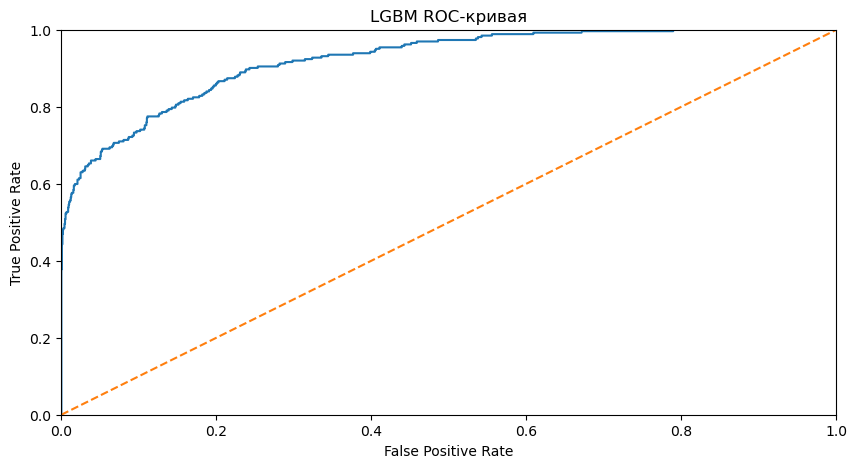

In [45]:
fpr, tpr, thresholds = roc_curve(target_test, predictions, pos_label=1)
plt.figure(figsize=(10,5))
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LGBM ROC-кривая')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

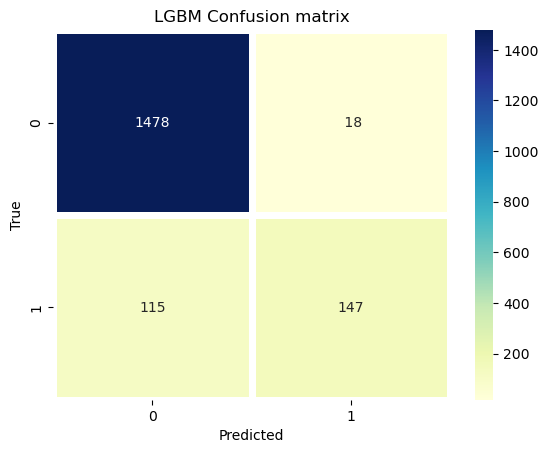

In [46]:
sns.heatmap(confusion_matrix(target_test, best_model_lgbm.predict(features_test)), annot=True, fmt='3.0f', 
            cmap='YlGnBu', linecolor='white', linewidths=5)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('LGBM Confusion matrix');

ROC-кривая и матрица ошибок показали, что качество модели высокое, она редко ошибается и чаще отвечает верно

Выведем график важности признаков для модели LGBM:

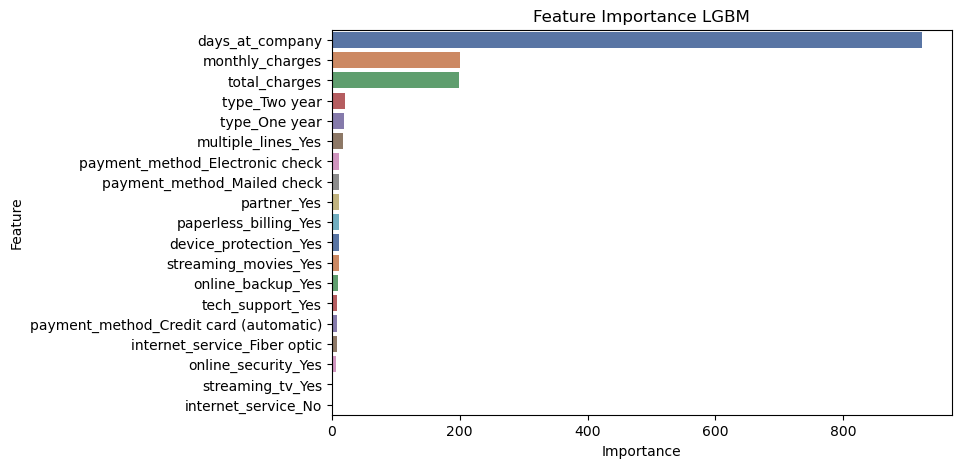

In [47]:
importance = best_model_lgbm.feature_importances_
feature_names = features_train.columns
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance = feature_importance.sort_values('Importance', ascending=False).reset_index(drop=True)

plt.figure(figsize=(8, 5))
sns.barplot(data=feature_importance, y='Feature', x='Importance', palette='deep')
plt.title('Feature Importance LGBM')
plt.show()

Наиболее важные признаки для модели LGBM: `days_at_company`, `total_charges`, `monthly_charges` и `type`.

**Вывод:**
- мы преобразовали категориальные признаки, используя метод One-Hot Encoding (OHE)
- сохранили в переменных features и target признаки и целевой признак, и разделили выборку на обучающую и тестовую в соотношении 3:1
- Обучили модели Random Forest Classifier, Cat Boost Classifier и LGBM Classifier на кросс-валидации, подобрали для них гиперпараметры с помощью RandomizedSearchCV, оценили качество метриками AUC-ROC и Accuracy
- худшие значения метрик на крос-валидации показала модель случайного леса, лучшие значения метрик показала модель Cat Boost Classifier, при этом LGBM Classifier практически не уступает в качестве (AUC-ROC 0.907, accuracy 0.913), но обучается значительно быстрее. Для проверки на тестовой выборке взяли модель LGBM, она показала результаты на тестовой выборке: AUC-ROC 0.923, Accuracy 0.930
- построили матрицу ошибок, ROC-кривую и график важности признаков для получения дополнительной информации о производительности модели, выяснили, что наиболее важными признаками для модели LGBM являются days_at_company, total_charges и monthly_charges и `type`, убедились в высоком качестве модели и в том, что ее ответы не случайны, модель редко ошибается и чаще отвечает верно

# Отчет по проекту

1. Проект был выполнен без отклонений от плана: была проведена предобработка и анализ данных, преобразование категориальных признаков методом OHE и маштабирование численных, разделение на тренировочную и тестовую выборки, а также обучены модели `RandomForestClassifier`, `CatBoostClassifier` и `LGBMClassifier` (которая была протестирована как модель с лучшими результатами метрик), в качестве метрики качества были использованы ROC-AUC и дополнительно accuracy (точность не ниже 85%), после тестирования модели подкрепили расчеты визуализацией (ROC-кривая, матрица ошибок и график важности признаков для модели).


2. В ходе работы возникли трудности, связанные с большим количеством времени, потраченным на подбор гиперпараметров через `GridSearch`, поэтому было принято решение использовать `RandomSearch`, что существенно ускорило процесс, при этом качество моделей осталось таким же высоким.


3. Ключевыми шагами при выполнении проекта хотелось бы выделить предобработку и анализ данных, так как они существенно влияют на качество будущей модели и соответственно на цель проекта: предобработка помогает повысить качество данных, а анализ помогает понять какие признаки не важны для дальнейшего анализа.


4. Для обучения моделей использовались следующие признаки:
    - **категориальные:** 
       - `type`, `paperless_billing`, `payment_method`, `internet_service`, `online_security`, `online_backup`, `device_protection`, `tech_support`, `streaming_tv`, `streaming_movies`, `multiple_lines`, `partner` - предобработка этих признаков не потребовалась, данные корректны
    - **числовые:**
       - `monthly_charges` - предобработка не потребовалась (данные корректны)
       - `total_charges` - на этапе предобработки были обнаружены пропуски, которые относилисьтся к пользователям, подключенным к тарифу в день выгрузки базы данных (2020-02-01), таких значений было слишком мало (менее 1%), заменять их было не целесообразно и строки с пропущенными значениями мы удалили, а также заменили тип данных object на float
       - `days_at_company` - признак, который мы создали, показывающий как долго клиент находится в компании, им мы заменили сразу два признака end_date и begin_date
    - **целевой признак:**
       - `left_the_company` - признак, который мы создали основываясь на данные признака end_date (в дальнейшем был удален): если дата ухода клиента из компании была равна дате выгрузки данных, то такие клиенты были определены в группу оставшихся клиентов, все остальные были определены в группу покинувших компанию.
     
Все категориальные признаки после предобработки были закодированы методом `One-Hot encoding`, а числовые масштабированы методом `StandardScaler`, также мы изучили дисбаланс классов, но метрика, по которой оценивались модели не чувствительна к дисбалансу, поэтому было принято решение оставить данные несбалансированными.


5. Итоговой моделью была выбрана `LGBMClassifier` так как ее качество было высоким, а скорость обучения значительно превышала скорость остальных рассматриваемых моделей. Гиперпараметры: 'reg_lambda' = 1, 'n_estimators' = 1000, 'max_depth' = 2, 'learning_rate' = 0.3, random_state = 120623. На тренировочной выборке модель показала результаты `AUC-ROC = 0.9057 и Accuracy = 0.9182`, на тестовой выборке `AUC-ROC 0.9240, Accuracy 0.9334`.